In [1]:
from glob import glob
import pywt
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt

# Framework for analysis

In the following, we will set the framework how we will work with audio data based on 1 audio example.  

In [13]:
audio_files = glob("./data/original/*/*.wav")
audio_files[:10]

['./data/original/german/german10_male_darmstadt_germany.wav',
 './data/original/german/german23_male_herdecke_germany.wav',
 './data/original/german/german15_male_innsbruck_austria.wav',
 './data/original/german/german5_male_halle_germany.wav',
 './data/original/german/german9_male_wuppertal_germany.wav',
 './data/original/german/german3_female_meissen_germany.wav',
 './data/original/german/german38_female_kaiserslautern_germany.wav',
 './data/original/german/german1_female_dusseldorf_germany.wav',
 './data/original/german/german19_female_offenbach_germany.wav',
 './data/original/german/german40_female_leipzig_germany.wav']

In [3]:
# play audio file
ipd.Audio(audio_files[0])

In [16]:
signal, sample_rate = librosa.load(audio_files[0])
print(f"the sampling rate is {sample_rate} Hz")

the sampling rate is 22050 Hz


In [23]:
signal

array([-0.00887681, -0.00993147, -0.00644147, ..., -0.04261993,
       -0.05224689,  0.        ], dtype=float32)

Signal = numpy array that contains the number of values equal to sampling rate multiplied by the duration

Each signal value is the amplitude of the waveform

In [18]:
file_duration_sec = len(signal)/sample_rate
print(f"file duration is {round(file_duration_sec, 2)} sec")

file duration is 21.49 sec


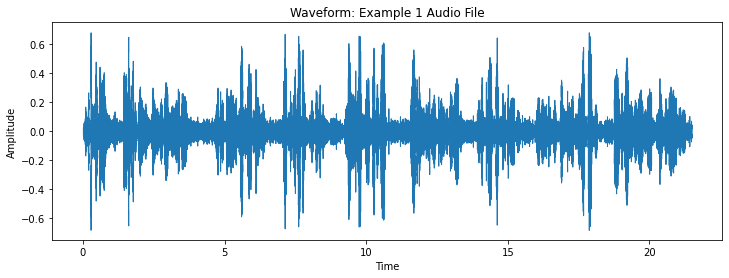

In [19]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(signal, sr=sample_rate)
plt.title("Waveform: Example 1 Audio File")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

# Fast Fourier Transform

**Based on this Source**: 
- https://ataspinar.com/2018/04/04/machine-learning-with-signal-processing-techniques/
- https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/

Any signal can be decomposed into a sum of simpler signals. These simpler signals are trigonometric functions (sine and cosine waves). By multiplying signal with a series of sine-waves with different frequences, we are able to determine which frequencies are present in a signal. If the dot-product between the signal and a sine wave of a certain frequency results into a large amplitude, this means that the signal contains this specific frequency (i.e. the dot-product measures how two vectors/signals overlap).


The math function that transforms a signal from the time domain to the frequency-domain is called Fourier Transform. The frequency domain shows us at which frequencies the component signals oscillate.

Fast Fourier Transform is the standard to calculate Descrete Fourier Transform (DFT) and can be calculated using numpy (np.fft.fft()) or scipy libraries (from scipy.fftpack import fft)

FFT function returns a vector of complex valued frequencies, containing a real and imaginary part. The real part corresponds to the magnitude, the imagniary part - to the phase of the signal. Since we are only interested in the magnitude of the amplitudes, we use np.abs() to take the real part of the frequency spectrum.

FFT of an input signal of N points will return a vector of N points. The first half of this vector (N/2) contains useful values of the frequency spectrum from 0 Hz to the Nyquist frequency of fs/2. The second half contains the complex conjugate and can be disregarded since it doesn't provide useful information.



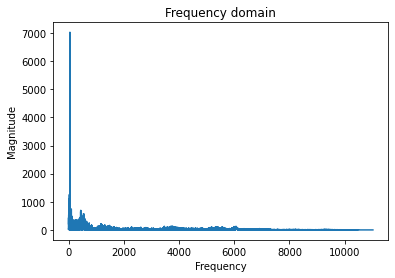

In [7]:
fft = np.fft.fft(signal)
# For each value of fft we get complex values 
# -> need to take absolute to get magnitude of the values
magnitude = np.abs(fft)
frequency = np.linspace(0, sample_rate, len(magnitude))
# need only half of the frequencies (property of Fourier Transform)
left_frequency = frequency[:int(len(frequency)/2)]
left_magnitude = magnitude[:int(len(frequency)/2)]
plt.plot(left_frequency, left_magnitude)
plt.title("Frequency domain")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

## Problem with Fourier Transform: 

Fourier Transform has a very high resolution in the frequency domain, and zero resolution in the time domain. We know at which frequencies the signal oscillates, but do not know at which time these oscillations occur.

To maintain information about the time domain, we can do **Short Fast Fourier Transform** to get a spectogram or **Continuous Wavelet Transform** to get a scaleogram.

# 1. Spectogram with Short-Time Fourier Transform

In Short-Time Fourier Transform (STFT), the original signal is splitted into several parts of equal length (which may or may not overlap) by using a sliding window before applying Fourier Transform. 

With SFFT, we slide a window of size n_fft (number of samples) by hop_length, an interval that tells us how much we are shifting the window towards the right in time and for each interval we calculate FFT.

STFT parameters:<br>
n_fft = window size<br>
hop_length = interval to slide window

The problem with STFT - uncertainty principle. The smaller the window size, the more we know about time where the frequency occured but less about the frequency value itself. The larger the window size, the more we learn about the frequency value and less about time where it occured.


In [8]:
n_fft = 2048
hop_length = 512

# calculate duration hop length and window in seconds
hop_length_duration = float(hop_length)/sample_rate
n_fft_duration = float(n_fft)/sample_rate

print("STFT hop length duration is: {}s".format(hop_length_duration))
print("STFT window duration is: {}s".format(n_fft_duration))


STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


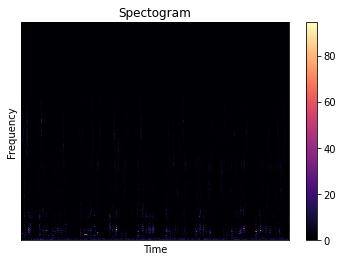

In [9]:

stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)
spectogram = np.abs(stft)
librosa.display.specshow(spectogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.title("Spectogram")
plt.show()

Very low frequencies.
To get a nicer picture we calculate log-spectogram

librosa.amplitude_to_db -> converts an amplitude spectrogram to dB-scaled spectrogram.

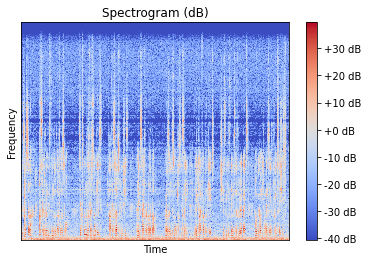

In [10]:
log_spectogram = librosa.amplitude_to_db(spectogram)
librosa.display.specshow(log_spectogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")
plt.show()

# 2. Scaleogram with Continuous Wavelet Transform (CWT)

**Based on Source**: https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/

Wavelet Transform has high resolution in both frequency and time domains, i.e. it tells us both which frequencies are present in the signal and when they occured. Unlike SFFT which works with same window size, CWT works with different scales. 
First, we look at signal with large scale and analyze large features, then we look at signal with smaller scale and analyze smaller features.

While Fourier Transform is based on linear combination of sine waves, Wavelet Transform uses a series of functions called wavelets, each with a different scale. The main difference is that sine wave is not localized in time, while wavelet is localized in time. This allows the wavelet to obtain information in time domain in addition to frequency domain.

![wavelet-vs-sine](https://ataspinar.com/wp-content/uploads/2018/07/Wavelet-Out1.jpg)
Source: https://ataspinar.com/wp-content/uploads/2018/07/Wavelet-Out1.jpg

Since wavelet is localized in time, we can multiply the signal with the wavelet at different locations in time. We start at the beginning of our signal and slowly move the wavelet towards the end of the signal. The procedure is also known as **convolution**. After we have done this for the original wavelet, we can scale it larger and repeat the process.

The result of Wavelet Transform can be plotted as a scaleogram that gives information about dynamic behavior of the signal. The two dimensions of a scaleogram are time and scales.

See: https://handwiki.org/wiki/Continuous_wavelet_transform#/media/File:Continuous_wavelet_transform.gif

There are different wavelet families that can help focus on specific features. Each type of wavelets has different shape, compactness, smoothness useful for a different purpose.

![wavelets](https://ataspinar.com/wp-content/uploads/2018/08/wavelet_families.png)
Source: https://ataspinar.com/wp-content/uploads/2018/08/wavelet_families.png

In [11]:
print(pywt.families(short=False))

['Haar', 'Daubechies', 'Symlets', 'Coiflets', 'Biorthogonal', 'Reverse biorthogonal', 'Discrete Meyer (FIR Approximation)', 'Gaussian', 'Mexican hat wavelet', 'Morlet wavelet', 'Complex Gaussian wavelets', 'Shannon wavelets', 'Frequency B-Spline wavelets', 'Complex Morlet wavelets']


# TODO: CWT

# 3. Mel-frequency cepstral coefficients (MFCCs) 

**Source:** 
11- Preprocessing audio data for Deep Learning
https://www.youtube.com/watch?v=Oa_d-zaUti8&list=PL-wATfeyAMNrtbkCNsLcpoAyBBRJZVlnf&index=11

code:
https://github.com/musikalkemist/DeepLearningForAudioWithPython/blob/master/12-%20Music%20genre%20classification:%20Preparing%20the%20dataset/code/extract_data.py

Mel-frequency cepstral coefficients (MFCCs) are a type of feature that is commonly used in speech processing and music information retrieval. They are derived from the Fourier transform of a signal and represent its spectral content in a way that is similar to the human auditory system.

MFCCs are commonly used as inputs to machine learning algorithms that are designed to analyze and classify audio data. Because they capture the spectral content of a signal in a way that is similar to how the human ear perceives it, they can be effective at capturing important characteristics of the audio data that are relevant for tasks such as speech recognition and music classification.

To compute MFCCs, the following steps are typically performed:

1. Apply a Fourier transform to the audio signal to convert it from the time domain to the frequency domain. This results in a representation of the signal in which each frequency component is represented by a complex number.

2. Convert the frequency domain representation of the signal from a linear scale to a Mel scale. This is done by applying a nonlinear transformation that maps low frequencies to a smaller range of values than high frequencies, in a way that is similar to how the human ear perceives pitch.

3. Apply a logarithmic function to the Mel-scaled spectrum. This compresses the range of values in the spectrum, making it more amenable to analysis by a machine learning algorithm.

4. Apply a discrete cosine transform (DCT) to the log-scaled Mel-spectrum. This decorrelates the features in the spectrum, resulting in a set of coefficients that can be used as features for a machine learning model.
The resulting MFCCs are a compact representation of the spectral content of the audio signal that can be used as inputs to machine learning algorithms for tasks such as speech recognition and music classification.

MFCC stands for Mel-Frequency Cepstral Coefficients, which are a representation of the spectral content of a sound. The steps to compute MFCCs are as follows:

1. Compute the short-time Fourier transform (STFT) of the audio signal. This is done by applying a sequence of windowed Fourier transforms to the signal. This step is performed using the following formula: $f_{mel} = 2595 \log_{10} \left(1 + \frac{f}{700}\right)$, where $f$ is the frequency in Hz and $f_{mel}$ is the frequency on the Mel scale.

2. We can now compute the magnitude and phase of the STFT. This is done by taking the absolute value and angle (in radians) of the complex-valued STFT, respectively.

3. Next, we need to convert the magnitude spectrum from the linear scale to the logarithmic Mel scale. The Mel scale is a nonlinear scale that is designed to more closely match the perceived spectrum of human hearing.

4. Apply the discrete cosine transform (DCT) to the log power spectrum to decorrelate the coefficients and reduce the dimensionality of the representation. This step is performed using the following formula:
$c_k = \alpha_k \sum_{n=0}^{N-1} x[n] \cos\left(\frac{\pi}{N}(n+\frac{1}{2})k\right)$, where $c_k$ are the DCT coefficients, $x[n]$ are the log power spectrum values, $N$ is the number of filters, and $\alpha_k$ is a normalization constant.

The resulting coefficients, $c_k$, are the MFCCs. These coefficients can be used to represent the spectral content of the sound in a compact and efficient manner.

In [1]:
# extract 13 MFCCs
MFCCs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

# display MFCCs
librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
plt.title("MFCCs")

# show plots
plt.show()

NameError: name 'librosa' is not defined

# Conclusion: 

In this notebook, we set the framework for analysis. Audio signals can be analyzed using Fourier Transform, which decomposes the signal into different frequencies. Shortcoming of Fourier Transform is that it doesn't keep information about time. In order to maintain time dimension, we can use the following approaches:
- Short-Time Fourier Transform
- Continuous Wavelet Transform
- Mel-frequency cepstral coefficients

The result of each of the approaches can be plotted as an image: spectogram in case STFT, scaleogram in case of CWT and variation of spectogram in case of MFCC.

These images can then be analyzed with Convolutional Neural Networks (CNNs).

# References:

1. Valerio Velardo (2020): "The Sound of AI: Deep Learning (for Audio) with Python" (YouTube series):<br>
[11 Preprocessing audio data for Deep Learning](
https://www.youtube.com/watch?v=Oa_d-zaUti8&list=PL-wATfeyAMNrtbkCNsLcpoAyBBRJZVlnf&index=11) + [code](
https://github.com/musikalkemist/DeepLearningForAudioWithPython/blob/master/12-%20Music%20genre%20classification:%20Preparing%20the%20dataset/code/extract_data.py)


2. Ahmet Taspinar (2018):<br>
["A guide for using the Wavelet Transform in Machine Learning"](https://ataspinar.com/2018/12/21/a-guide-for-using-the-wavelet-transform-in-machine-learning/) <br>
["Machine Learning with Signal Processing Techniques"](https://ataspinar.com/2018/04/04/machine-learning-with-signal-processing-techniques/) <br> [code](https://github.com/taspinar/siml/tree/master/notebooks)


3. Rob Mulla (2022): ["Audio Data Processing in Python" (YouTube Tutorial)](https://www.youtube.com/watch?v=ZqpSb5p1xQo)
